In [7]:
#import necessary librabry
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
import os
import shutil
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [11]:
#
base_dir = r'C:/Users/jayas/Downloads/archive (1)/data1a'
train_dir = os.path.join(base_dir, 'training')
validation_dir = os.path.join(base_dir, 'validation')

# Create directories for split data
split_train_dir = os.path.join(base_dir, 'split_training')
split_test_dir = os.path.join(base_dir, 'split_test')

# Create the directories if they don't exist
for dir_path in [split_train_dir, split_test_dir]:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        os.makedirs(os.path.join(dir_path, '00-damage'))
        os.makedirs(os.path.join(dir_path, '01-whole'))

# Function to split data
def split_data(source_dir, train_dir, test_dir, test_size=0.3):
    files = os.listdir(source_dir)
    train_files, test_files = train_test_split(files, test_size=test_size, random_state=42)

    for file in train_files:
        shutil.copy(os.path.join(source_dir, file), train_dir)
    for file in test_files:
        shutil.copy(os.path.join(source_dir, file), test_dir)

#defining the damage and whole , train nand validation directory
train_damage_dir = os.path.join(train_dir, '00-damage')
train_whole_dir = os.path.join(train_dir, '01-whole')
validation_damage_dir = os.path.join(validation_dir, '00-damage')
validation_whole_dir = os.path.join(validation_dir, '01-whole')

# Split the damage and whole images
split_data(os.path.join(train_dir, '00-damage'), os.path.join(split_train_dir, '00-damage'), os.path.join(split_test_dir, '00-damage'))
split_data(os.path.join(train_dir, '01-whole'), os.path.join(split_train_dir, '01-whole'), os.path.join(split_test_dir, '01-whole'))


#data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,       # Random rotation between 0 and 40 degrees
                                   width_shift_range=0.2,   # Random width shifts
                                   height_shift_range=0.2,  # Random height shifts
                                   shear_range=0.2,         # Shear transformations
                                   horizontal_flip=True,    # Random horizontal flips
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        split_train_dir,  
        target_size=(150, 150), 
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')






Found 1288 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


In [18]:
#test generator
test_generator = test_datagen.flow_from_directory(
        split_test_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 552 images belonging to 2 classes.


In [12]:
#defining model
from tensorflow.keras import Model 
from tensorflow.keras.applications import VGG16

base_model = VGG16(input_shape = (150, 150, 3),  include_top = False, weights = 'imagenet',) 
base_model.Trainable=False

x=   tf.keras.layers.Flatten()(base_model.output)
x=   tf.keras.layers.Dense(512, activation='relu')(x) 
x=   tf.keras.layers.Dense(1, activation='sigmoid')(x) 

model= Model( base_model.input, x)

model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy','precision','recall'])


#training the model
history = model.fit(
      train_generator,
      epochs=15,
      batch_size = 32,
      validation_data=validation_generator,
      verbose=2)


Epoch 1/15


C:\Users\jayas\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 - 957s - 23s/step - accuracy: 0.6545 - loss: 0.6246 - precision: 0.6645 - recall: 0.6242 - val_accuracy: 0.7978 - val_loss: 0.4381 - val_precision: 0.7438 - val_recall: 0.9087
Epoch 2/15
41/41 - 953s - 23s/step - accuracy: 0.7725 - loss: 0.4731 - precision: 0.7854 - recall: 0.7500 - val_accuracy: 0.8804 - val_loss: 0.2988 - val_precision: 0.8855 - val_recall: 0.8739
Epoch 3/15
41/41 - 1027s - 25s/step - accuracy: 0.8261 - loss: 0.4157 - precision: 0.8355 - recall: 0.8121 - val_accuracy: 0.8609 - val_loss: 0.3420 - val_precision: 0.7986 - val_recall: 0.9652
Epoch 4/15
41/41 - 861s - 21s/step - accuracy: 0.8533 - loss: 0.3480 - precision: 0.8594 - recall: 0.8447 - val_accuracy: 0.8326 - val_loss: 0.3512 - val_precision: 0.7703 - val_recall: 0.9478
Epoch 5/15
41/41 - 641s - 16s/step - accuracy: 0.8797 - loss: 0.2960 - precision: 0.8814 - recall: 0.8773 - val_accuracy: 0.8239 - val_loss: 0.4352 - val_precision: 0.7475 - val_recall: 0.9783
Epoch 6/15
41/41 - 1084s - 26s/step - accurac

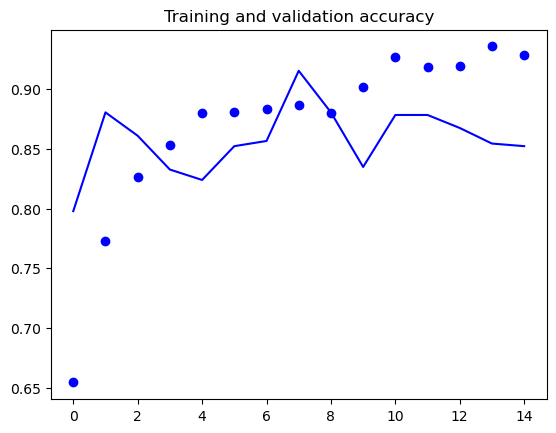

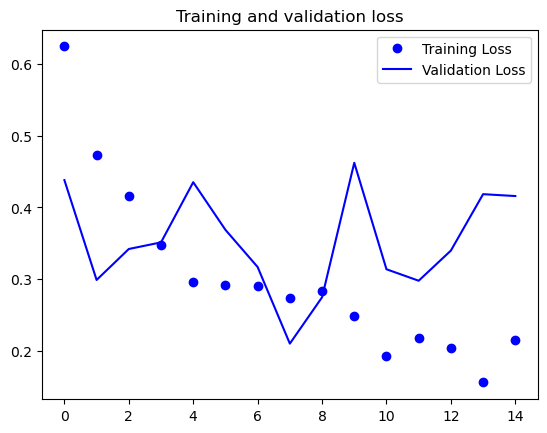

In [14]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Class Indices: {'00-damage': 0, '01-whole': 1}
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.7617 - loss: 0.5229 - precision: 0.7054 - recall: 0.9334
Test Loss: 0.4898
Test Accuracy: 0.7790
Test Precision: 0.7092
Test Recall: 0.9457
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Confusion Matrix:
[[ 6  6]
 [ 0 20]]


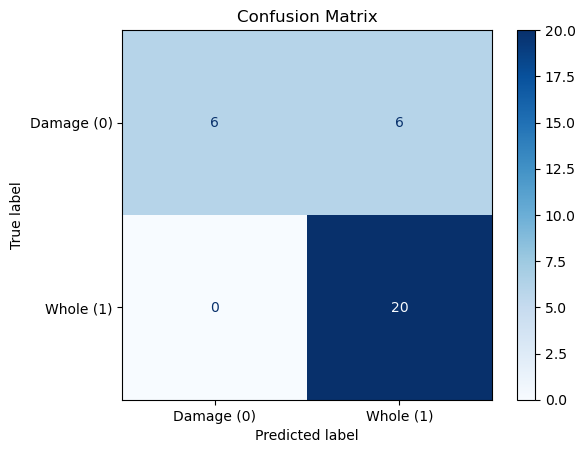

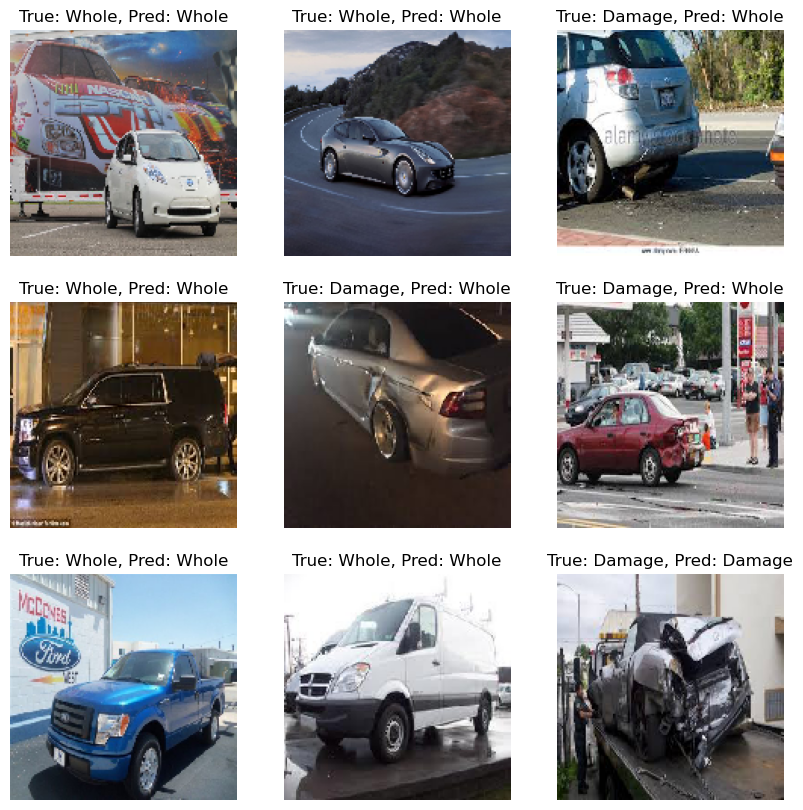

In [20]:
# Assuming train_generator or test_generator is already defined

# Print class indices to verify encoding
print("Class Indices:", train_generator.class_indices)

# Evaluate the model on test data
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')

# Make predictions
test_images, test_labels = next(test_generator)
predictions = model.predict(test_images)

predictions_binary = np.where(predictions <= 0.5, 0, 1)

# Create confusion matrix
cm = confusion_matrix(test_labels, predictions_binary)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
labels = ['Damage (0)', 'Whole (1)']  # Define class labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Visualize predictions
def plot_predictions(images, labels, predictions):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        
        # True label
        true_label = 'Damage' if labels[i] == 0 else 'Whole'
        
        # Predicted label
        predicted_label = 'Damage' if predictions[i] <= 0.5 else 'Whole'  
        
        plt.title(f'True: {true_label}, Pred: {predicted_label}')
        plt.axis('off')
    plt.show()

plot_predictions(test_images, test_labels, predictions)
